In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
random_state=0

In [2]:
df= pd.read_csv('winequality.csv')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,residual sugar
0,7.4,0.70,0.00,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1.9
1,7.8,0.88,0.00,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,2.6
2,7.8,0.76,0.04,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2.3
3,11.2,0.28,0.56,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1.9
4,7.4,0.70,0.00,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1.9


In [4]:
X = df.iloc[:, :-1] 
y = df.iloc[:, -1] 


In [5]:
y

0       1.9
1       2.6
2       2.3
3       1.9
4       1.9
       ... 
1594    2.0
1595    2.2
1596    2.3
1597    2.0
1598    3.6
Name: residual sugar, Length: 1599, dtype: float64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.20,random_state=0)

In [7]:
ranf = RandomForestRegressor(random_state=0)
rf= ranf.fit(X_train,y_train)
scores_rf= cross_val_score(rf, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores_rf
#print(np.mean(scores_rf))

y_pred_rf = cross_val_predict(ranf, X_test,y_test)
scores_test_rf= cross_val_score(ranf, X_test, y_test,scoring='neg_mean_squared_error',cv=10)
print(np.mean(scores_test_rf))


#Decision Tree
dectree = DecisionTreeRegressor(random_state = 0)
dt= dectree.fit(X_train,y_train)
scores_dt= cross_val_score(dt, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
#print(np.mean(scores_dt))

y_pred_dt = cross_val_predict(dectree, X_test,y_test)
scores_test_dt= cross_val_score(dectree, X_test, y_test,scoring='neg_mean_squared_error',cv=10)
print(np.mean(scores_test_dt))


# Instance and fit
knn_model = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)
y_pred_knn = cross_val_predict(knn_model, X_test,y_test)
scores_test_knn= cross_val_score(knn_model, X_test, y_test,scoring='neg_mean_squared_error',cv=10)
print(np.mean(scores_test_knn))

-1.3819467648437502
-2.4197421875
-1.5563928125


kappa = 1.000, avg MSE = 1.953
kappa = 2.000, avg MSE = 1.932
kappa = 3.000, avg MSE = 1.933
kappa = 4.000, avg MSE = 1.949
kappa = 5.000, avg MSE = 1.985
kappa = 6.000, avg MSE = 2.036
kappa = 7.000, avg MSE = 2.090
kappa = 8.000, avg MSE = 2.142
kappa = 9.000, avg MSE = 2.190
kappa = 10.000, avg MSE = 2.234


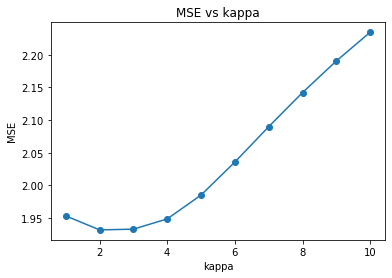

In [8]:
def impute_missing_values(X_train, X_test, y_train, kappa):
    y_train_np = y_train.to_numpy()
    mean_values = X_train.apply(lambda col: y_train.groupby(X_train[col.name]).mean())

    unique_values = {col: X_train[col].unique() for col in X_train.columns}
    imputed_values_train = {}
    imputed_values_test = {}

    for col in X_train.columns:
        imputed_values_train[col] = {val: mean_values[col][val] for val in unique_values[col]}
        imputed_values_test[col] = {val: mean_values[col][val] for val in unique_values[col] if val in X_test[col].unique()}

        extra_values = set(X_test[col].unique()) - set(unique_values[col])
        if extra_values:
            X_train_imputed = X_train.copy()
            X_test_imputed = X_test.copy()

    for col in X_train.columns:
        X_train_imputed[col] = X_train[col].map(imputed_values_train[col])

    for col in X_test.columns:
        X_test_imputed[col] = X_test[col].apply(lambda x: imputed_values_test[col].get(x, np.nan))

    for col in X_test_imputed.columns:
        missing_indices = X_test_imputed[X_test_imputed[col].isna()].index

        if len(missing_indices) > 0:
            d = np.linalg.norm(X_test.loc[missing_indices].values[:, np.newaxis] - X_train.values, axis=2)

            for i, idx in enumerate(missing_indices):
                l = 0
                v = 0
                for j in range(len(y_train)):
                    l += y_train_np[j] / ((1 + d[i, j]) ** kappa)
                    v += 1 / ((1 + d[i, j]) ** kappa)
                imputed_value = l / v
                X_test_imputed.at[idx, col] = imputed_value

    return X_train_imputed, X_test_imputed

X_trainnew, X_testnew=impute_missing_values(X_train, X_test, y_train, kappa=2)

X_test= X_testnew
X_train= X_trainnew


def prop_reg(X_test,X_train,y_train,y_test,kappa):
    d = np.zeros((len(X_test),len(X_train)))
    for i in range(len(X_test)):
        for j in range(len(X_train)):
            d[i,j] = np.linalg.norm(X_test[i]-X_train[j])
    c=np.zeros(len(y_test))
    for i in range(len(y_test)):
        l=0
        v=0
        for j in range(len(y_train)):
            
            l+=y_train[j]/((1+d[i,j])**kappa)
            v+=1/((1+d[i,j])**kappa)
        
        c[i]=l/v
    return(c)

kf = KFold(n_splits=10)
kappa_values = np.array([1,2,3,4,5,6,7,8,9,10])
mse_values = []

for kappa in kappa_values:
    mse = 0.0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        y_pred = prop_reg(X_test, X_train, y_train, y_test, kappa)
        mse += mean_squared_error(y_test, y_pred)
    mse /= kf.get_n_splits(X)
    mse_values.append(mse)
    print(f"kappa = {kappa:.3f}, avg MSE = {mse:.3f}")

# plot the MSE vs kappa curve
plt.plot(kappa_values, mse_values, '-o')
plt.xlabel('kappa')
plt.ylabel('MSE')
plt.title('MSE vs kappa')
plt.show()

In [9]:
# find the index of the minimum MSE value
min_index = np.argmin(mse_values)

# print the minimum MSE value and the corresponding kappa value
print(f"Minimum MSE: {mse_values[min_index]:.3f}, Kappa value: {kappa_values[min_index]}")


Minimum MSE: 1.932, Kappa value: 2
